In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings('ignore')


In [3]:
df=pd.read_csv('Credit Score Classification Dataset.csv')
df.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


In [12]:
df.describe()

,Age,Income,Number of Children
count,164.000000,164.000000,164.000000
mean,37.975610,83765.243902,0.652439
std,8.477289,32457.306728,0.883346
min,25.000000,25000.000000,0.000000
25%,30.750000,57500.000000,0.000000
50%,37.000000,83750.000000,0.000000
75%,45.000000,105000.000000,1.000000
max,53.000000,162500.000000,3.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 164 non-null    int64 
 1   Gender              164 non-null    object
 2   Income              164 non-null    int64 
 3   Education           164 non-null    object
 4   Marital Status      164 non-null    object
 5   Number of Children  164 non-null    int64 
 6   Home Ownership      164 non-null    object
 7   Credit Score        164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB


In [5]:
df['Education'].value_counts()

Bachelor's Degree      42
Master's Degree        36
Doctorate              31
High School Diploma    30
Associate's Degree     25
Name: Education, dtype: int64

In [9]:
df.isnull().sum()

Age                   0
Gender                0
Income                0
Education             0
Marital Status        0
Number of Children    0
Home Ownership        0
Credit Score          0
dtype: int64

**EDA**

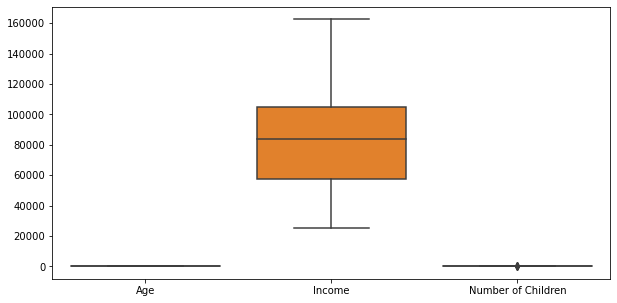

In [11]:
plt.figure(figsize=(10,5), facecolor='white')
sns.boxplot(data=df)
plt.show()


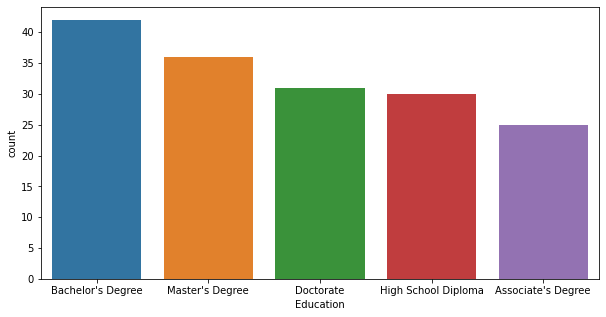

In [13]:
plt.figure(figsize=(10,5), facecolor='white')
sns.countplot(x='Education', data=df)
plt.show()

In [18]:
df['Marital Status'].value_counts()

Married    87
Single     77
Name: Marital Status, dtype: int64

Text(0, 0.5, '')

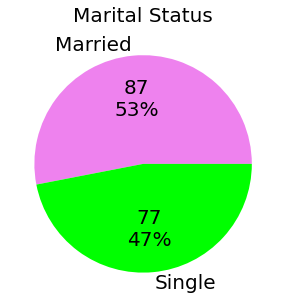

In [41]:
plt.figure(figsize=(10,5), facecolor='white')
plt.title('Marital Status', size=20)
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
ax=df.groupby('Marital Status').size().plot(kind='pie', autopct=label_function , textprops={'fontsize': 20},
                                 colors=['violet', 'lime'])
ax.set_ylabel('')

Text(0, 0.5, '')

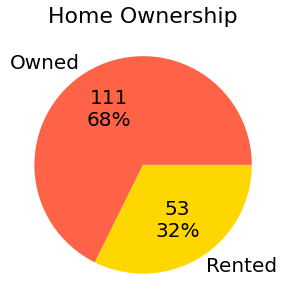

In [40]:
plt.figure(figsize=(10,5), facecolor='white')
plt.title('Home Ownership', size=22)
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
ax=df.groupby('Home Ownership').size().plot(kind='pie', autopct=label_function , textprops={'fontsize': 20},
                                 colors=['tomato', 'gold'])
ax.set_ylabel('')

Text(0, 0.5, '')

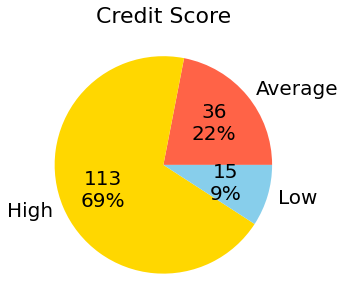

In [43]:
plt.figure(figsize=(10,5), facecolor='white')
plt.title('Credit Score', size=22)
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
ax=df.groupby('Credit Score').size().plot(kind='pie', autopct=label_function , textprops={'fontsize': 20},
                                 colors=['tomato', 'gold','skyblue'])
ax.set_ylabel('')

**Preprocesing**

In [44]:
def make_mi_score(x,y):
    x = x.copy()
    for colname in x.select_dtypes(['object','category']):
        x[colname], _ = x[colname].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    mi_score = mutual_info_classif(x,y,discrete_features=discrete_features,random_state=0)
    mi_score = pd.Series(mi_score,name='Mutual Information Score',index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [46]:
X=df.drop('Credit Score', axis=1)
y=df['Credit Score']
make_mi_score(X,y)

Income                0.710131
Age                   0.690220
Home Ownership        0.476695
Education             0.284546
Marital Status        0.258410
Number of Children    0.160422
Gender                0.065297
Name: Mutual Information Score, dtype: float64

In [47]:
#Delete the column with the lowest score
X.drop('Gender', axis=1, inplace=True)

In [48]:
cat_col=X.select_dtypes(include=['object']).columns.tolist()
num_col=X.select_dtypes(include=['int64','float64']).columns.tolist()

In [54]:
num_pip=make_pipeline(StandardScaler())
cat_pip=make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))

In [55]:
preprocessor=make_column_transformer((num_pip,num_col),(cat_pip,cat_col))
X=preprocessor.fit_transform(X)

In [56]:
X

array([[-1.53531997, -1.04348337, -0.74086152, ...,  1.        ,
         0.        ,  1.        ],
       [-0.94370231,  0.50172   ,  1.53019061, ...,  0.        ,
         1.        ,  0.        ],
       [-0.35208465, -0.27088169,  0.39466455, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.12120947, -0.65718253,  1.53019061, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.71282713,  0.11541915, -0.74086152, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.30444478, -0.19362152,  0.39466455, ...,  0.        ,
         1.        ,  0.        ]])

In [66]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0)

**Build Modeling**

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [84]:
Rf=RandomForestClassifier(n_estimators=1000, random_state=0)
Rf.fit(X_train,y_train)
y_pred=Rf.predict(X_val)
print('Classification Report:\n', classification_report(y_val,y_pred))

Classification Report:
               precision    recall  f1-score   support

     Average       0.83      1.00      0.91         5
        High       1.00      0.96      0.98        27
         Low       1.00      1.00      1.00         1

    accuracy                           0.97        33
   macro avg       0.94      0.99      0.96        33
weighted avg       0.97      0.97      0.97        33

